<a href="https://colab.research.google.com/github/thotran2015/6.871/blob/master/ICU_Mortality_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

## Loading Data


In [0]:
auth.authenticate_user()

#### Lab Data

In [0]:
!gsutil cp gs://hst-956/adult_icu.gz ./


In [0]:
lab_df = pd.read_csv('adult_icu.gz')

#### Note Data

In [0]:
!gsutil cp gs://hst-956/adult_notes.gz ./


In [0]:
note_df = pd.read_csv('adult_notes.gz')

In [0]:
def get_best_model(model, parameters, X_val, y_val):
  clf = GridSearchCV(model, parameters)
  clf.fit(X_val, y_val)
  return clf.best_estimator_

## Question 2

Predicting hospital mortality from lab values



In [0]:
lab_df.head()

In [0]:
fea_note_df = lab_df.drop(columns=['subject_id',	'hadm_id','icustay_id', 'mort_hosp', 'mort_icu',	'mort_oneyr', 'train', 'test', 'valid'])
scaled_note_df = pd.DataFrame(preprocessing.scale(fea_note_df), columns = fea_note_df.columns)
scaled_note_df[['train', 'test', 'valid', 'mort_hosp','real_age']] = lab_df[['train', 'test', 'valid', 'mort_hosp', 'age']]

In [0]:
df_train = scaled_note_df[scaled_note_df['train'] ==1]
df_test = scaled_note_df[scaled_note_df['test'] ==1]
df_val = scaled_note_df[scaled_note_df['valid'] ==1]

X_train = df_train[fea_note_df.columns]
y_train = df_train['mort_hosp']
X_test = df_test[fea_note_df.columns]
y_test = df_test['mort_hosp']
X_val = df_val[fea_note_df.columns]
y_val = df_val['mort_hosp']

model = LogisticRegression(solver = 'liblinear')
parameters = {'C':[0.1,0.25,0.5,1.], 'penalty':['l1','l2']}

In [0]:
df_test.head(2)

In [0]:
best_model = get_best_model(model, parameters, X_val, y_val)
best_model.fit(X_train, y_train)

In [0]:
test_acc = best_model.score(X_test,y_test)
print('Test accuracy: ', test_acc)

In [0]:
best_model

In [0]:
y_score = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score)
print('AUC score: ', auc)

In [0]:
y_pred = best_model.predict(X_test)
print('Confusion Matrix')
confusion_matrix(y_test, y_pred)

##Features and their Weights

In [0]:
pd.DataFrame({'feature': fea_note_df.columns, 'coef': best_model.coef_[0]}).sort_values(by='coef', ascending = False)

2.1) What do the columns seem to mean? If we wanted to predict in-hospital mortality, which column would we use as the outcome column? Which columns would be features and which columns would NOT be features?

Using sklearn, train a logistic regression classifier on the training data while optimizing for best train accuracy, find the best hyperparameters among C=[0.1,0.25,0.5,1.] and penalty=[‘l1’,’l2’] on validation data. Normalize your feature values to have zero mean and unit variance.

2.2) What is the accuracy on test data? What is the AUC? Create a confusion matrix of your predictions against reality. Look at the proportion of patients who died in the hospital, and explain why might one metric be more informative than the other.

2.3) What are the most predictive features, based on the the coefficients of the logistic regression? Comment on your findings.

## Question 3

Predicting hospital mortality from clinical notes


In [0]:
note_df.head()

In [0]:
note_train, note_test, note_val = note_df[note_df['train']==1], note_df[note_df['test']==1], note_df[note_df['valid']==1]

In [0]:
vectorizer = CountVectorizer(max_features= 5000)
vectorizer.fit(note_train['chartext'])

In [0]:
note_Xtrain, note_ytrain = vectorizer.transform(note_train['chartext']), note_train['mort_hosp']
note_Xtest, note_ytest = vectorizer.transform(note_test['chartext']), note_test['mort_hosp']
note_Xval, note_yval = vectorizer.transform(note_val['chartext']), note_val['mort_hosp']

In [0]:
model_note = LogisticRegression(solver = 'liblinear')
parameters = {'C':[0.1,0.25,0.5,1.], 'penalty':['l1','l2']}
best_model_note= get_best_model(model_note, parameters, note_Xval, note_yval)


In [0]:
best_model_note.fit(note_Xtrain, note_ytrain)

In [0]:
note_test_acc = best_model_note.score(note_Xtest, note_ytest)
print('Test accuracy: ', note_test_acc)

In [0]:
note_yscore = best_model_note.predict_proba(note_Xtest)[:, 1]
note_auc = roc_auc_score(note_ytest, note_yscore)
print('AUC score: ', note_auc)

In [0]:
note_ypred = best_model_note.predict(note_Xtest)
print('Confusion Matrix')
confusion_matrix(note_ytest, note_ypred)

In [0]:
words = pd.DataFrame(vectorizer.vocabulary_.items(), columns= ['word', 'index']).set_index('index').sort_values(by='index')
words['coef'] = best_model_note.coef_[0]

In [0]:
neg_words = words.sort_values(by='coef')[-10:]

In [0]:
pos_words = words.sort_values(by='coef')[:10]

In [0]:
pos_words

In [0]:
neg_words

In [0]:
max_id = words['coef'].idxmax(axis = 0)
words.iloc[max_id]

3.1) What is the accuracy and AUC on the test data? How do these results compare to structured data results?

3.2) What words are the most predictive (positive and negative) of hospital mortality? Look up any unknown clinical definitions and comment on a few.

## Question 4

Analysis of data and results

##Process ethnicity and mortality columns


In [0]:
mort_eth_df = lab_df[['mort_hosp','eth_asian','eth_black','eth_hispanic',	'eth_other', 'eth_white']]
mort_eth_df.sum()

In [0]:
asian = mort_eth_df[mort_eth_df['eth_asian']==1][['mort_hosp', 'eth_asian']].sum()
black = mort_eth_df[mort_eth_df['eth_black']==1][['mort_hosp', 'eth_black']].sum()
hisp = mort_eth_df[mort_eth_df['eth_hispanic']==1][['mort_hosp', 'eth_hispanic']].sum()
other = mort_eth_df[mort_eth_df['eth_other']==1][['mort_hosp', 'eth_other']].sum()
white = mort_eth_df[mort_eth_df['eth_white']==1][['mort_hosp', 'eth_white']].sum()

## Ethnicity Population, Mortality Rate 

In [0]:
[(eth[1], eth[0]/eth[1]) for eth in [asian, black, hisp, other, white]]

In [0]:
lab_df[['age']].plot.hist(bins = 10)

In [0]:
bucket_age = lab_df.groupby(pd.cut(lab_df["age"], np.arange(0, 100, 10)))['age'].count()

In [0]:
bucket_mort = lab_df.groupby(pd.cut(lab_df["age"], np.arange(0, 100, 10)))['mort_hosp'].sum()

In [0]:
count_mort_rate = pd.DataFrame([bucket_age, bucket_mort, bucket_mort/bucket_age], index = ['age_count', 'mort_hosp', 'mort_rate']).T

In [0]:
count_mort_rate

In [0]:
count_mort_rate['mort_rate'].plot(x = 'age', y ='mort_rate', legend = True, kind= 'bar')

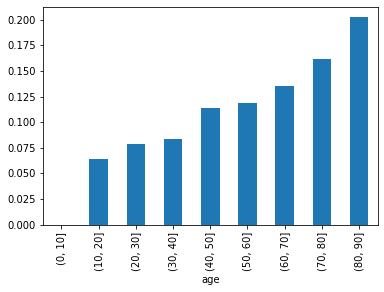

The age bucket that has the highest mortality rate is (80, 90] years old. The one with the lowest rate is (10, 20]. This outcome is expected since older people tend to have a higher chance of dying in the hospital. 

4.1) For each of the 5 ethnic categorizations provided in adult_icu.gz, how many people belong to each group? Are the hospital mortality rates the same for each group?

1. eth_asian:         618; mort_rate : 0.15210355987055016
2. eth_black:        2581; mort_rate: 0.15210355987055016
3. eth_hispanic:      881; mort_rate: 0.10442678774120318
4. eth_other:        3904; mort_rate: 0.1875
5. eth_white:       19364; mort_rate: 0.1361805412104937



4.2) Create a histogram of the ages in the dataset (in buckets of 10: 20-29, 30-39, etc), and another histogram of mortality rates per bucket. What bucket has the highest mortality? The lowest?

4.3) So that your answer doesn't depend on whether you found the best model in #2, retrain a model on the training set using C=1 and penalty='l2'. Evaluate your new model (AUC, accuracy) on patients in the test set who are less than 40, and patients in the test set who are older than 40. For what group is performance better? Can you hypothesize why?

In [0]:
new_model = LogisticRegression(solver = 'liblinear', C= 1, penalty='l2')
new_model.fit(X_train, y_train)
test_u40 = df_test[df_test['real_age'] < 40]
test_o40 = df_test[df_test['real_age'] > 40]
X_test_u40, y_test_u40 = test_u40[fea_note_df.columns], test_u40['mort_hosp']
X_test_o40, y_test_o40 = test_o40[fea_note_df.columns], test_o40['mort_hosp']

In [0]:
print('under 40 accuracy: ', new_model.score(X_test_u40, y_test_u40))
print('over 40 accuracy: ', new_model.score(X_test_o40, y_test_o40))

1. under 40 accuracy:  0.9390243902439024
2. over 40 accuracy:  0.8584924623115577



In [0]:
y_score_u40 = new_model.predict_proba(X_test_u40)[:,1]
y_score_o40 = new_model.predict_proba(X_test_o40)[:,1]
print('under 40 auc: ', roc_auc_score(y_test_u40, y_score_u40))
print('over 40 auc: ', roc_auc_score(y_test_o40, y_test_o40))

1. under 40 auc:  0.8644300144300144
2. over 40 auc:  1.0


